<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/cat_vs_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  23.2M      0  0:00:33  0:00:33 --:--:-- 30.7M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip  'readme[1].txt'
 drive			   PetImages		        sample_data


In [ ]:
sourse_path = 'PetImages'

In [ ]:
os.listdir(sourse_path)

['Dog', 'Cat']

In [ ]:
cat_dir = os.path.join(sourse_path, 'Cat')
dog_dir = os.path.join(sourse_path, 'Dog')
print(f'Count of image in Cat folder {len(os.listdir(cat_dir))}')
print(f'Count of image in Dog folder {len(os.listdir(dog_dir))}')

Count of image in Cat folder 12501
Count of image in Dog folder 12501


In [ ]:
import os

num_skipped = 0
skiped_files = []
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(sourse_path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            skiped_files.append(fpath)
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
cat_dir = os.path.join(sourse_path, 'Cat')
dog_dir = os.path.join(sourse_path, 'Dog')
print(f'Count of image in Cat folder {len(os.listdir(cat_dir))}')
print(f'Count of image in Dog folder {len(os.listdir(dog_dir))}')

Count of image in Cat folder 11742
Count of image in Dog folder 11670


In [ ]:
IMG_SIZE = 180

train_raw_ds, val_raw_ds = tf.keras.utils.image_dataset_from_directory(
    sourse_path,
    batch_size = 128,
    labels='inferred',
    shuffle=True,
    seed=1234,
    validation_split=0.2,
    subset='both',
    image_size = (IMG_SIZE, IMG_SIZE)
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [ ]:
aug_train = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.1)
])

aug_val = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
train_ds = train_raw_ds.map(lambda x,label: (aug_train(x), label), num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_raw_ds.map(lambda x,label: (aug_val(x), label), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for x, y in train_ds.take(1):
    print(x.shape)
    print(y.shape)

(128, 180, 180, 3)
(128,)


In [ ]:
def early_stopping_callback(monitor='val_loss', patience=5, verbose=1):
    es = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        verbose=verbose,
        restore_best_weights='True'
    )
    return es

In [ ]:
# create LetNet model
def LeNet5_model(input_shape):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = input_shape),
        #tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(filters = 6, kernel_size=(5,5), strides = 1, activation = 'relu'),
        tf.keras.layers.AvgPool2D(2, strides = 2),
        tf.keras.layers.Conv2D(filters = 16, kernel_size=(5,5), strides = 1, activation = 'relu'),
        tf.keras.layers.AvgPool2D(2, strides = 2),
        tf.keras.layers.Conv2D(filters = 120, kernel_size=(5,5), strides = 1, activation = 'relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(84, 'relu'),
        tf.keras.layers.Dense(10, 'relu'),
        tf.keras.layers.Dense(1,'sigmoid')])
    return model

In [ ]:
leNet_model = LeNet5_model((IMG_SIZE, IMG_SIZE,3))
leNet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 176, 176, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 88, 88, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_10 (Conv2D)          (None, 84, 84, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 42, 42, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_11 (Conv2D)          (None, 38, 38, 120)       48120     
                                                                 
 flatten_3 (Flatten)         (None, 173280)           

In [ ]:
tf.keras.utils.plot_model(leNet_model)

In [ ]:
ES = early_stopping_callback()
leNet_model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'] )
history_leNet = leNet_model.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=[ES], verbose = 1)

Epoch 1/100
147/147 [==============================] - 46s 84ms/step - loss: 0.6864 - accuracy: 0.5493 - val_loss: 0.6683 - val_accuracy: 0.5989
Epoch 2/100
147/147 [==============================] - 42s 78ms/step - loss: 0.6394 - accuracy: 0.6382 - val_loss: 0.6195 - val_accuracy: 0.6555
Epoch 3/100
147/147 [==============================] - 42s 78ms/step - loss: 0.6122 - accuracy: 0.6688 - val_loss: 0.6095 - val_accuracy: 0.6670
Epoch 4/100
147/147 [==============================] - 42s 78ms/step - loss: 0.6067 - accuracy: 0.6732 - val_loss: 0.6036 - val_accuracy: 0.6745
Epoch 5/100
147/147 [==============================] - 42s 78ms/step - loss: 0.5977 - accuracy: 0.6817 - val_loss: 0.5925 - val_accuracy: 0.6841
Epoch 6/100
147/147 [==============================] - 42s 78ms/step - loss: 0.5914 - accuracy: 0.6883 - val_loss: 0.5809 - val_accuracy: 0.6916
Epoch 7/100
147/147 [==============================] - 42s 79ms/step - loss: 0.5868 - accuracy: 0.6901 - val_loss: 0.5944 - val_ac

In [ ]:
leNet_model.evaluate(val_ds)

147/147 [==============================] - 3s 17ms/step - loss: 0.4060 - accuracy: 0.8199


[0.40602561831474304, 0.8199487328529358]

In [ ]:
leNet_model.save('LeNet_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
def simple_model(input_shape):
    model = tf.keras.Sequential([
        #tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
model = simple_model((IMG_SIZE, IMG_SIZE, 3))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 128)      

In [ ]:
ES = early_stopping_callback()
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'] )
s_h = model.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=[ES])

Epoch 1/100
147/147 [==============================] - 51s 120ms/step - loss: 0.6497 - accuracy: 0.6351 - val_loss: 0.5678 - val_accuracy: 0.7072
Epoch 2/100
147/147 [==============================] - 37s 113ms/step - loss: 0.5162 - accuracy: 0.7427 - val_loss: 0.4611 - val_accuracy: 0.7817
Epoch 3/100
147/147 [==============================] - 37s 113ms/step - loss: 0.4659 - accuracy: 0.7797 - val_loss: 0.4611 - val_accuracy: 0.7813
Epoch 4/100
147/147 [==============================] - 37s 117ms/step - loss: 0.4266 - accuracy: 0.8005 - val_loss: 0.4175 - val_accuracy: 0.8048
Epoch 5/100
147/147 [==============================] - 37s 118ms/step - loss: 0.3898 - accuracy: 0.8222 - val_loss: 0.4169 - val_accuracy: 0.8093
Epoch 6/100
147/147 [==============================] - 39s 115ms/step - loss: 0.3553 - accuracy: 0.8428 - val_loss: 0.3700 - val_accuracy: 0.8364
Epoch 7/100
147/147 [==============================] - 37s 118ms/step - loss: 0.3289 - accuracy: 0.8559 - val_loss: 0.3534 -

In [ ]:
model.evaluate(val_ds)


37/37 [==============================] - 2s 42ms/step - loss: 0.3448 - accuracy: 0.8505


[0.3447887897491455, 0.8504912257194519]

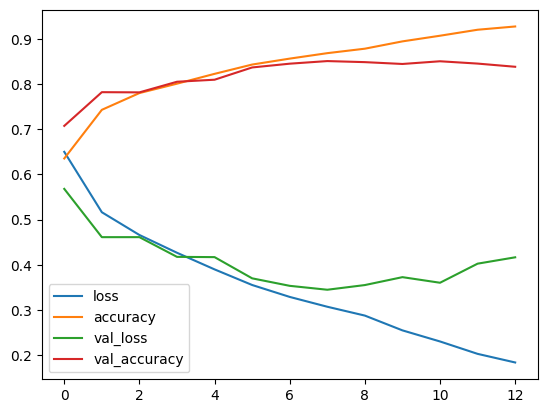

In [ ]:
pd.DataFrame(s_h.history).plot()
plt.show()


# Evaluation model

In [ ]:
# add more augmentation
aug_train = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.3)
])

aug_val = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
train_ds = train_raw_ds.map(lambda x,label: (aug_train(x), label), num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_raw_ds.map(lambda x,label: (aug_val(x), label), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def simple_model_dropout(input_shape):
    model = tf.keras.Sequential([
        #tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
model2 = simple_model_dropout((IMG_SIZE, IMG_SIZE,3))
model2.summary()

In [ ]:
batch_size = 128
ES = early_stopping_callback()
model2.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'] )
history2 = model2.fit(train_ds,
                epochs = 100,
                #steps_per_epoch = int(len(train_ds)//batch_size),
                validation_data = val_ds,
                #validation_steps = int(len(val_ds)//batch_size),
                callbacks=[ES])

# Keras model

In [ ]:
def keras_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    #x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)

In [ ]:
big_model = keras_model((IMG_SIZE, IMG_SIZE,3), 2)

In [ ]:
big_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 90, 90, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 90, 90, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 90, 90, 128)          0         ['batch_normalization[0][0

In [ ]:
ES = early_stopping_callback()
big_model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'] )
history_big_model = big_model.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=[ES])

Epoch 1/100
147/147 [==============================] - 118s 420ms/step - loss: 0.6709 - accuracy: 0.6204 - val_loss: 0.7435 - val_accuracy: 0.5028
Epoch 2/100
147/147 [==============================] - 91s 400ms/step - loss: 0.5743 - accuracy: 0.7023 - val_loss: 0.9554 - val_accuracy: 0.5028
Epoch 3/100
147/147 [==============================] - 92s 400ms/step - loss: 0.4854 - accuracy: 0.7722 - val_loss: 1.3412 - val_accuracy: 0.5028
Epoch 4/100
147/147 [==============================] - 92s 400ms/step - loss: 0.4194 - accuracy: 0.8140 - val_loss: 0.5192 - val_accuracy: 0.7302
Epoch 5/100
147/147 [==============================] - 92s 400ms/step - loss: 0.3756 - accuracy: 0.8360 - val_loss: 1.0133 - val_accuracy: 0.6337
Epoch 6/100
147/147 [==============================] - 91s 400ms/step - loss: 0.3453 - accuracy: 0.8503 - val_loss: 0.9915 - val_accuracy: 0.6576
Epoch 7/100
147/147 [==============================] - 92s 400ms/step - loss: 0.3161 - accuracy: 0.8657 - val_loss: 0.3396 

In [2]:
import pandas as pd
pd.DataFrame(history_big_model.history).plot()
plt.show()


NameError: ignored